In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pyBigWig

In [2]:
CTCF = pyBigWig.open('/data1/lmh_data/MINE/source/HepG2/CTCF.bigWig')
CEBPB = pyBigWig.open('/data1/lmh_data/MINE/source/HepG2/CEBPB.bigWig')
POLR2A = pyBigWig.open('/data1/lmh_data/MINE/source/HepG2/POLR2A.bigWig')
EZH2 = pyBigWig.open('/data1/lmh_data/MINE/source/HepG2/EZH2.bigWig')
H3K27ac = pyBigWig.open('/data1/lmh_data/MINE/source/HepG2/H3K27ac.bigWig')
H3K27me3 = pyBigWig.open('/data1/lmh_data/MINE/source/HepG2/H3K27me3.bigWig')
H3K9me3 = pyBigWig.open('/data1/lmh_data/MINE/source/HepG2/H3K9me3.bigWig')
GENES = pd.read_table("/data1/lmh_data/MINE/source/hg38_gc_cov_100kb.tsv")

In [3]:
def plot_bwTrack(ax, bw, ylabel, chrom, start, end, resolution=20000 , yminx=5, ymaxx=95,rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)

    plot_list = bw.stats(chrom, start, end, type="mean", nBins=x)
    plot_list = [0 if v is None else v  for v in plot_list]
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge",edgecolor=color)    
    ax.set_xlim(0,x)

    #ax.set_xticks([])
    #ax.set_xticklabels([])

    ymin = np.percentile(plot_list,yminx)
    ymax = np.percentile(plot_list,ymaxx)

    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')
   

In [4]:
def two_degree_bc(x_l=10, x_r=90, y_lr=0, y2=10, dots_num=100): #bezier curve
    xt = []
    yt = []
    x_mid = (x_l + x_r)/2
    x_dots12 = np.linspace(x_l, x_mid, dots_num)
    y_dots12 = np.linspace(y_lr, y2, dots_num)
    x_dots23 = np.linspace(x_mid, x_r, dots_num)
    y_dots23 = np.linspace(y2, y_lr, dots_num)
    for i in range(dots_num):
        x = x_dots12[i] + (x_dots23[i]-x_dots12[i])*i / (dots_num-1)
        y = y_dots12[i] + (y_dots23[i]-y_dots12[i])*i / (dots_num-1)
        xt.append(x)
        yt.append(y)
    return (xt, yt)

def plot_loop(ax, ylabel, file_path, chrom: int, start: int, end: int, FDR=0.5):
    if file_path.endswith('.npy'):
        loops = np.load(file_path, allow_pickle=True).item()
        loops = loops[chrom]
        loops = list(filter(lambda x: (x[0]>=start)&(x[1]<=end), loops))
        lengths = [loop[1]-loop[0] for loop in loops]
    else:
        loops = pd.read_table(file_path)
        loops = loops[loops['BIN1_CHR'].apply(str)==str(chrom)]
        loops = loops[loops['FDR'] <= FDR]
        lengths = loops["BIN2_START"] - loops["BIN1_START"]

        loops = loops[
            ((loops['BIN1_START'] >= start) & (loops['BIN1_START'] <= end)) |
            ((loops['BIN2_START'] >= start) & (loops['BIN2_START'] <= end) |
             (loops['BIN1_END'] >= start) & (loops['BIN1_END'] <= end)) |
            ((loops['BIN2_END'] >= start) & (loops['BIN2_END'] <= end))]
        loops = loops.apply(lambda x: (x['BIN1_START'], x['BIN2_START']), axis=1).values.tolist()

    if len(loops) == 0:
        for i in ['top', 'right', "left", "bottom"]:
            ax.spines[i].set_color('none')
            ax.spines[i].set_linewidth(0)
        return

    top_y = 0
    for loop, length in zip(loops, lengths):
        top = length / max(lengths)
        top = max(0.5, top)
        top = min(0.8, top)
        
        xt, yt = two_degree_bc(x_l=loop[0], x_r=loop[1], y_lr=0, y2=top, dots_num=100)
        
        ax.plot(xt, yt, color='#66AC84')
        if max(yt) > top_y:
            top_y = max(yt)

    ax.set_xlim(start,end)
    ax.set_ylim(0,0.5)
    ax.set_ylabel(ylabel, fontsize=8, rotation=0, horizontalalignment='right',verticalalignment='center')
    for i in ['top', 'right']:
        ax.spines[i].set_color('none')
        #ax.spines[i].set_linewidth(0.5)
        
    ax.spines["bottom"].set_color('black')
    ax.spines["bottom"].set_linewidth(1)  
    
    
    ax.tick_params(bottom =False,top=False,left=False,right=False)
    ax.set_xticklabels("")
    ax.set_yticklabels("")

In [5]:
def plot_gene(ax, gene_bed, ylabel, chrom, start, end, resolution=100000, rotation=0, fl='%0.2f',color
='#464451'):
    ax.tick_params(bottom=False,top=False,left=True,right=False)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['top'].set_color('none')
    ax.spines['top'].set_linewidth(0)
    ax.spines['right'].set_color('none')
    ax.spines['right'].set_linewidth(0)

    x = int((end-start)/resolution)
    
    plot_list = []
    for i in range(x):
        _start = int(int(start/resolution)*resolution) + resolution * i
        plot_list.append(
            gene_bed[
                (gene_bed['chrom']==chrom)&
                (gene_bed['start']>=_start)&
                (gene_bed['end']<=_start+resolution)]['geneNum'].sum())
    
    width = 1
    ax.bar(x=range(0,x), height=plot_list, width=1, bottom=[0]*(x),color=color,align="edge", edgecolor=color)    
    ax.set_xlim(0,x)

    ymin, ymax = min(plot_list), max(plot_list)
    
    ax.set_yticks([ymin, ymax])
    ax.set_yticklabels([fl % ymin, fl % ymax], fontsize=7)
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=8, rotation=rotation, horizontalalignment='right',verticalalignment='center')
    
    ax.set_xticks([])
    ax.set_xticklabels('')

In [6]:
def show(chrom, start, end, resolution, _path, FDR=0.5):
    fig = plt.figure(figsize=(12, 5), facecolor='white')
    plt.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.8, hspace=0.3, wspace=0.15)

    gs = fig.add_gridspec(10, 1)
    ax0 = fig.add_subplot(gs[0:2, 0], facecolor='white')
    ax1 = fig.add_subplot(gs[2, 0], facecolor='white')
    ax2 = fig.add_subplot(gs[3, 0], facecolor='white')
    ax3 = fig.add_subplot(gs[4, 0], facecolor='white')
    ax4 = fig.add_subplot(gs[5, 0], facecolor='white')
    ax5 = fig.add_subplot(gs[6, 0], facecolor='white')
    ax6 = fig.add_subplot(gs[7, 0], facecolor='white')
    ax7 = fig.add_subplot(gs[8, 0], facecolor='white')
    ax8 = fig.add_subplot(gs[9, 0], facecolor='white')

    ax0.set_title("{0}:{1}-{2}".format(chrom, start, end))

    #heatmap_triangle(ax0, cMat, ymax=200,chrom="20", start=start, end=end, 
    #                                     width=6, height=0.8, cmap=cmap3, showXticks=True, title="")

    plot_loop(
        ax0, 'MINE Loop(call by Mustache)',
        os.path.join(_path, 'enhanced/{}_1000b/mustache/enhanced_out_pt05.tsv'.format(chrom)),
        int(chrom[3:]), start, end, FDR)

    plot_bwTrack(ax1, CTCF, "CTCF", chrom, start, end, resolution=resolution , 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#62D6E3')
    
    plot_bwTrack(ax2, CEBPB, "CEBPB", chrom, start, end, resolution=resolution , 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#3A6569')
    
    plot_bwTrack(ax3, POLR2A, "POLR2A", chrom, start, end, resolution=resolution , 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#FAD048')
    
    plot_bwTrack(ax4, EZH2, "EZH2", chrom, start, end, resolution=resolution , 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='grey')

    plot_bwTrack(ax5, H3K27ac, "H3K27ac", chrom, start, end, resolution=resolution , 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#E69F00')

    plot_bwTrack(ax6, H3K27me3, "H3K27me3", chrom, start, end, resolution=resolution , 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='#EECFA1')
    
    plot_bwTrack(ax7, H3K9me3, "H3K9me3", chrom, start, end, resolution=resolution , 
                 yminx=0, ymaxx=100,rotation=0, fl='%0.2f',color='black')

    plot_gene(ax8, GENES, "GeneNum", chrom[3:], start, end, rotation=0, fl='%0.2f',color='green')

    fig.savefig("figure_file/{0}:{1}-{2}.pdf".format(chrom, start, end), format='pdf', bbox_inches='tight')

    plt.show()

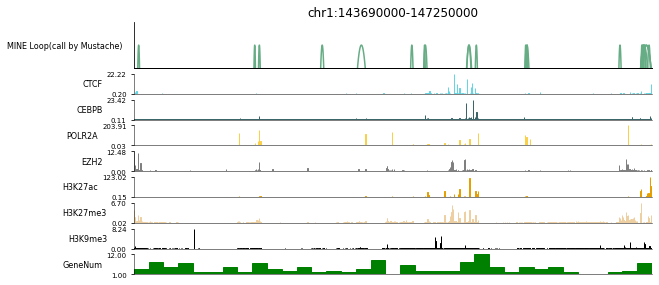

In [7]:
_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HepG2_ATAC_H3K27ac_H3K4me3/experiment/loop'
show("chr1", 143690000, 147250000, 1000, _path, FDR=0.3)  # 147

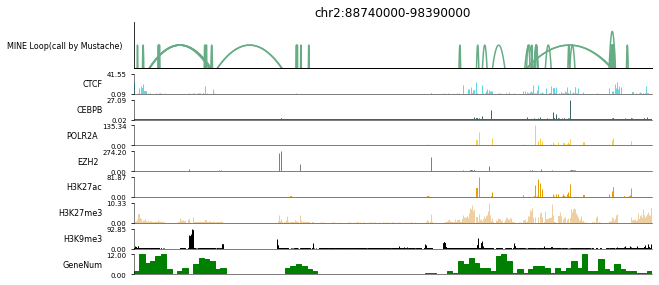

In [8]:
_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HepG2_ATAC_H3K27ac_H3K4me3/experiment/loop'
show("chr2", 88740000, 98390000, 1000, _path, FDR=0.3)  # 1379

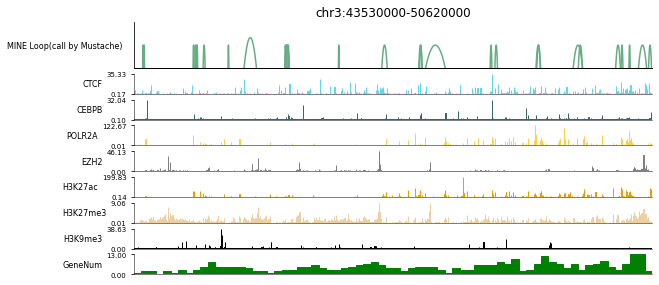

In [9]:
_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HepG2_ATAC_H3K27ac_H3K4me3/experiment/loop'
show("chr3", 43530000, 50620000, 1000, _path, FDR=0.3)  # 1727

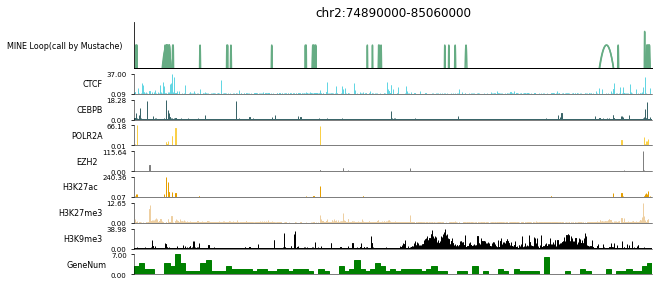

In [10]:
_path = '/data1/lmh_data/MINE/GM12878_ATAC_H3K27ac_H3K4me3/analyse/HepG2_ATAC_H3K27ac_H3K4me3/experiment/loop'
show("chr2", 74890000, 85060000, 1000, _path, FDR=0.3)  # 1372

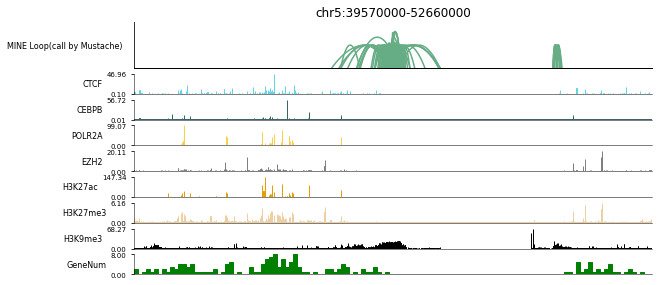

In [11]:
_path = '/data1/lmh_data/MINE/GM12878_H3K9me3_H3K27me3/analyse/HepG2_H3K9me3_H3K27me3/experiment/loop'
show("chr5", 39570000, 52660000, 1000, _path, FDR=0.3)  # 1961

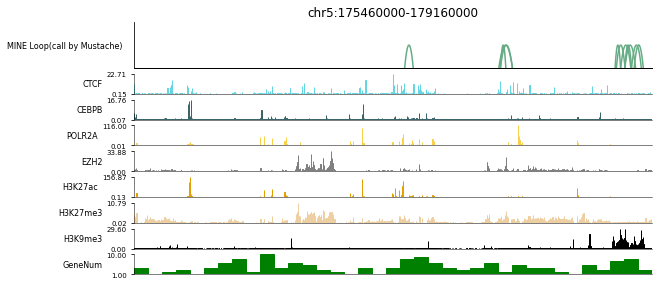

In [12]:
_path = '/data1/lmh_data/MINE/GM12878_H3K9me3_H3K27me3/analyse/HepG2_H3K9me3_H3K27me3/experiment/loop'
show("chr5", 175460000, 179160000, 1000, _path, FDR=0.3)  # 2084

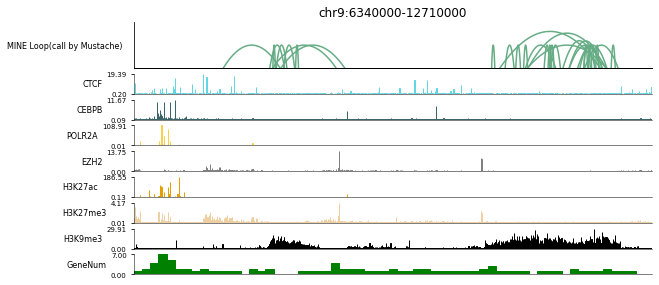

In [13]:
_path = '/data1/lmh_data/MINE/GM12878_H3K9me3_H3K27me3/analyse/HepG2_H3K9me3_H3K27me3/experiment/loop'
show("chr9", 6340000, 12710000, 1000, _path, FDR=0.3)  # 2497

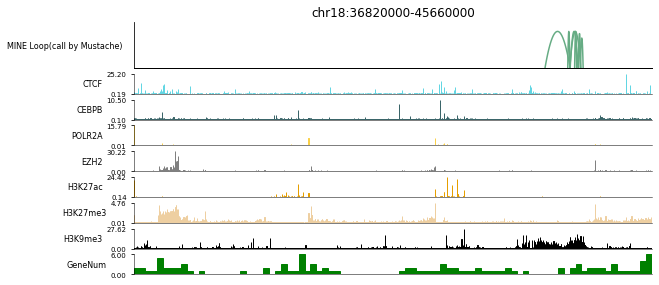

In [14]:
_path = '/data1/lmh_data/MINE/GM12878_H3K9me3_H3K27me3/analyse/HepG2_H3K9me3_H3K27me3/experiment/loop'
show("chr18", 36820000, 45660000, 1000, _path, FDR=0.3)  # 1178 